In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn import metrics
from imblearn.over_sampling import SMOTENC

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = w.get_cws_data()

In [4]:
train, validate, test, y_train, y_val, y_test, train_scaled, val_scaled, test_scaled = w.model_prep(df)

In [5]:
train.bad_resident.value_counts()

0    2692
1     107
Name: bad_resident, dtype: int64

In [10]:
def upsample(train):
    '''takes a train dataframe, upsamples minority and returns upsampled X_train and upsampled y_train'''
    
    
    df_majority = train[train.bad_resident ==0]
    df_minority = train[train.bad_resident ==1]
    df_minority_upsampled = resample(df_minority, replace=True, n_samples=300 , random_state=91)
    
    # get upsampled_df
    df_upsampled = pd.concat([df_minority_upsampled, df_majority])
    
    # scale df_upsampled
    df_upsampled[['rent', 'monthly_income', 'total_income','age', 'risk_score']] = StandardScaler().fit_transform(df_upsampled[['rent', 'monthly_income', 'total_income','age', 'risk_score']])
    
    # split scaled df_upsampled
    X_train_upsampled = df_upsampled.drop('bad_resident',axis=1)
    y_train_upsampled = df_upsampled['bad_resident']
    
    return X_train_upsampled, y_train_upsampled

In [11]:
def get_knn(train, X_validate, y_validate):
    ''' takes a train dataframe, X_ validate, y_validate, print KNN  confusion matrix and classifaction report on train and validate data'''
    
    # get upsampled X_train and Y_train
    X_train_upsampled, y_train_upsampled = upsample(train)
    
    # create model
    knn= KNeighborsClassifier(n_neighbors =3)

    # fit the model to train data
    knn.fit(X_train_upsampled, y_train_upsampled)
    
    # make prediction on train obeservations
    y_pred = knn.predict(X_train_upsampled)
    
    # make prediction on validate obeservations
    y_pred_val = knn.predict(X_validate)
    
    # get confusion matrix
    confusion_matrix_train = metrics.confusion_matrix(y_train_upsampled, y_pred)
    confusion_matrix_val = metrics.confusion_matrix(y_validate, y_pred_val)
    
    # print confusion matrix and classification report
#     print('Confusion Matrix of upsampled Train:')
#     print(confusion_matrix_train)
#     print('\n Classification Report on Train:')
#     print(classification_report(y_train_upsampled, y_pred))
#     print('-----------------------------------------------------------')
#     print('Confusion Matrix of Validate:')
#     print( confusion_matrix_val)
#     print('\n Classification Report on Validate: ')
#     print(classification_report(y_validate, y_pred_val))
#     print()
    
    df1 = pd.DataFrame(classification_report(y_train_upsampled, y_pred, labels=['0','1'], output_dict=True)).T
    df2 = pd.DataFrame(classification_report(y_validate, y_pred_val, labels=['0','1'], output_dict=True)).T
    
#     print(df1.iloc[0:2,0:2])
#     print()
#     print(df2.iloc[0:2,0:2])

    train_df = df1.iloc[0:2,1:2]
    validate_df = df2.iloc[0:2,1:2]
    
#     train_df.rename(columns = {'precision':'precision_train_KNN', 'recall': 'recall_train_KNN'}, inplace=True)
#     validate_df.rename(columns = {'precision':'precision_validate_KNN', 'recall': 'recall_validate_KNN'}, inplace=True)

    train_df.rename(columns = {'recall': 'recall_train'}, inplace=True)
    validate_df.rename(columns = {'recall': 'recall_validate'}, inplace=True)

    concated_df = pd.concat([train_df,validate_df],axis=1) 
    recall_KNN_df = concated_df.iloc[1:2,0:2]
    
    return recall_KNN_df

In [12]:
kk = get_knn(train, val_scaled, y_val)
kk

,recall_train,recall_validate
1,0.94,0.130435


In [13]:
kkk = get_knn(train, val_scaled, y_val)
kkk

,recall_train,recall_validate
1,0.94,0.130435


In [14]:
merged = pd.concat([kk,kkk])
merged

,recall_train,recall_validate
1,0.94,0.130435
1,0.94,0.130435


In [15]:
merged.index = ['apple', 'ball']

In [ ]:
merged

In [16]:
def get_models_recall(train, val_scaled, y_val):
    '''takes train, x_train, y_train, x_validate, y_validate
    return dataframe with models and their recall score on train and validate data
    '''
    knn_df1 = get_knn(train, val_scaled, y_val)
    knn_df2 = get_knn(train, val_scaled, y_val)
    
    
    
    # concat dataframe
    concated_df = pd.concat([knn_df1,knn_df2])
    # assign index
    
    return concated_df

In [17]:
concated_df = get_models_recall(train, val_scaled, y_val)
concated_df 

,recall_train,recall_validate
1,0.94,0.130435
1,0.94,0.130435


In [18]:
def viz_models_accuracy(df):
   
    '''takes in a dataframe and plot a graph to show comparisons models accuracy score on train and valiadate data'''
    
    df_1 = df.copy()
    df_1.recall_train = df_1.recall_train * 100
    df_1.recall_validate = df_1.recall_validate * 100
    
    ax = df_1.plot.bar(rot=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(False)
    plt.title("Comparisons of Recall of Models")
    plt.ylabel('Recall score')
    plt.bar_label(ax.containers[0],fmt='%.0f%%')
    plt.bar_label(ax.containers[1],fmt='%.0f%%')
    
    plt.show()

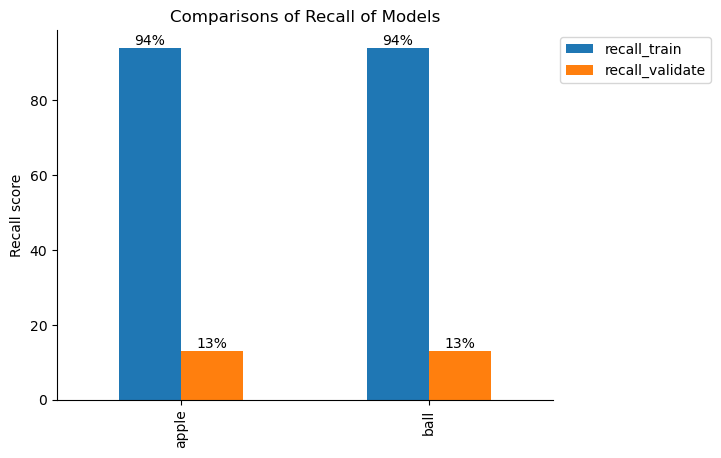

In [19]:
viz_models_accuracy(merged)

In [24]:
def viz_models_accuracy(df):
   
    '''takes in a dataframe and plot a graph to show comparisons models accuracy score on train and valiadate data'''
    
    df_1 = df.copy()
    df_1.recall_train = df_1.recall_train * 100
    df_1.recall_validate = df_1.recall_validate * 100
    
    ax = df_1.plot.bar(rot=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Comparisons of Recall of Models")
    plt.ylabel('Recall score')
    plt.bar_label(ax.containers[0],fmt='%.0f%%')
    plt.bar_label(ax.containers[1],fmt='%.0f%%')
    ax.grid(False)
    plt.show()




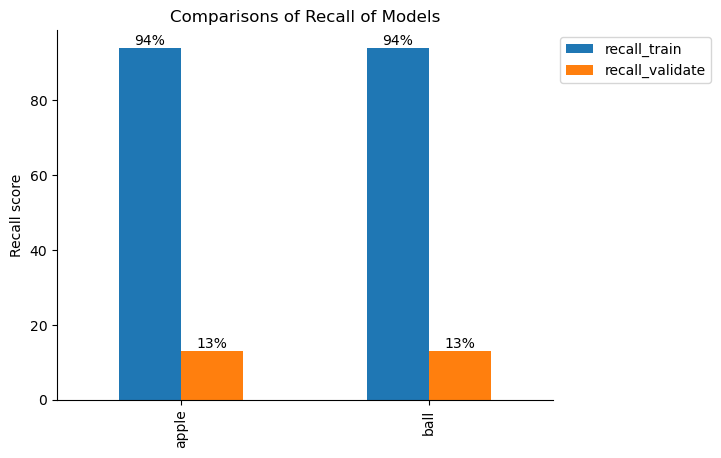

In [25]:
viz_models_accuracy(merged)